In [17]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in triplet stim elecResps and amplitudes

In [18]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity_cosine"

In [19]:
dataset = "2020-10-18-0"
estim = "data003/data003-all"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [20]:
wnoise = "kilosort_data000/data000"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [27]:
p = 2
n = 6

p_thr = 2/19
p_upper = 1
random_state = 0

In [28]:
filepath = os.path.join(gsort_path, 
                        dataset, estim, wnoise, "p" + str(p))

triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)

num_pts = len(amplitudes)

triplet_probs = np.zeros(num_pts)
triplet_trials = np.zeros(num_pts, dtype=int)
for k in range(num_pts):
    with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
        prob_dict = pickle.load(f)
        triplet_probs[k] = prob_dict["cosine_prob"][0]
        triplet_trials[k] = prob_dict["num_trials"]

good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

y = triplet_probs[good_inds]
X = amplitudes[good_inds]
trials = triplet_trials[good_inds]

full_clustering = SpectralClustering(n_clusters=2, 
                                assign_labels='discretize',
                                affinity='nearest_neighbors', 
                                random_state=random_state).fit(X)

full_cluster1 = good_inds[np.where(full_clustering.labels_ == 0)[0]]
full_cluster2 = good_inds[np.where(full_clustering.labels_ == 1)[0]]

/tmp/ipykernel_18724/1606224036.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


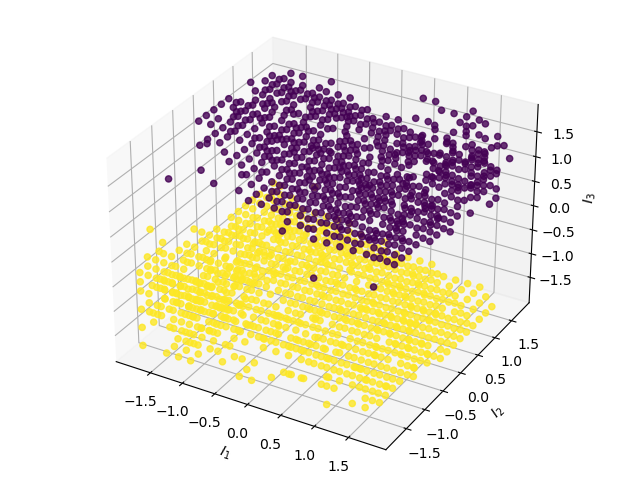

In [31]:
fig = plt.figure(68)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(X[:, 0], 
            X[:, 1],
            X[:, 2], marker='o', s=20, c=full_clustering.labels_, alpha=0.8)

plt.show()

In [ ]:
init_size = 100
batch_size = 5
degree = 2
l2_reg = 0

poly = PolynomialFeatures(degree)
OLS_X_1_full = poly.fit_transform(amplitudes[full_cluster1], degree)
# OLS_X_2_full = poly.fit_transform(all_amps[full_cluster2], degree)
OLS_y_1_full = np.log(triplet_probs[full_cluster1] / (1 - triplet_probs[full_cluster1]))
# OLS_y_2_full = np.log(all_probs[full_cluster2] / (1 - all_probs[full_cluster2]))

OLS_w_1_full = (np.linalg.inv(l2_reg * np.eye(OLS_X_1_full.shape[-1]) + OLS_X_1_full.T @ OLS_X_1_full) @ OLS_X_1_full.T) @ OLS_y_1_full
# OLS_w_2_full = (np.linalg.inv(l2_reg * np.eye(OLS_X_2_full.shape[-1]) + OLS_X_2_full.T @ OLS_X_2_full) @ OLS_X_2_full.T) @ OLS_y_2_full

init_inds = np.random.choice(np.arange(len(amplitudes)), size=init_size, replace=False)
curr_inds = init_inds
remaining_inds = np.setdiff1d(np.arange(len(amplitudes)), curr_inds)

while len(curr_inds) < 500:
    # clustering = SpectralClustering(n_clusters=2, 
    #                                 assign_labels='discretize',
    #                                 affinity='nearest_neighbors', 
    #                                 random_state=random_state).fit(all_amps[curr_inds])

    # cluster1 = np.where(clustering.labels_ == 0)[0]
    # cluster2 = np.where(clustering.labels_ == 1)[0]
    curr_good_inds = np.where((triplet_probs[curr_inds] > p_thr) & (triplet_probs[curr_inds] < p_upper))[0]

    OLS_X_1 = poly.fit_transform(all_amps[curr_inds[cluster1]], degree)
    # OLS_X_2 = poly.fit_transform(all_amps[curr_inds[cluster2]], degree)

    OLS_y_1 = np.log(all_probs[curr_inds[cluster1]] / (1 - all_probs[curr_inds[cluster1]]))
    OLS_y_2 = np.log(all_probs[curr_inds[cluster2]] / (1 - all_probs[curr_inds[cluster2]]))

    cov_1 = np.linalg.inv(l2_reg * np.eye(OLS_X_1.shape[-1]) + (OLS_X_1.T @ OLS_X_1))
    cov_2 = np.linalg.inv(l2_reg * np.eye(OLS_X_2.shape[-1]) + (OLS_X_2.T @ OLS_X_2))
    
    A_1 = cov_1 - l2_reg * cov_1 @ cov_1
    A_2 = cov_1 - l2_reg * cov_2 @ cov_2

    # print(A_1)

    OLS_w_1 = (np.linalg.inv(l2_reg * np.eye(OLS_X_1.shape[-1]) + OLS_X_1.T @ OLS_X_1) @ OLS_X_1.T) @ OLS_y_1
    OLS_w_2 = (np.linalg.inv(l2_reg * np.eye(OLS_X_2.shape[-1]) + OLS_X_2.T @ OLS_X_2) @ OLS_X_2.T) @ OLS_y_2
    # print(OLS_w_1, OLS_w_2)

    acc_1 = max(np.mean(np.absolute(fitting.fsigmoid(OLS_X_1_full, OLS_w_1) - all_probs[full_cluster1]) < 0.1), 
                np.mean(np.absolute(fitting.fsigmoid(OLS_X_1_full, OLS_w_2) - all_probs[full_cluster1]) < 0.1))
    acc_2 = max(np.mean(np.absolute(fitting.fsigmoid(OLS_X_2_full, OLS_w_1) - all_probs[full_cluster2]) < 0.1), 
                np.mean(np.absolute(fitting.fsigmoid(OLS_X_2_full, OLS_w_2) - all_probs[full_cluster2]) < 0.1))
    # print(acc_1, acc_2)

    V = poly.fit_transform(all_amps[remaining_inds], degree)
    next_inds_1 = np.argsort(np.diag(V @ A_1 @ V.T))[-batch_size:]
    next_inds_2 = np.argsort(np.diag(V @ A_2 @ V.T))[-batch_size:]

    # next_inds = remaining_inds[np.unique(np.concatenate((next_inds_1, next_inds_2)))]
    next_inds = np.random.choice(remaining_inds, replace=False, size=2*batch_size)
    # print(next_inds)
    # print(all_amps[next_inds])

    curr_inds = np.concatenate((curr_inds, next_inds))
    remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

clustering = SpectralClustering(n_clusters=2, 
                                    assign_labels='discretize',
                                    affinity='nearest_neighbors', 
                                    random_state=random_state).fit(all_amps[curr_inds])

In [ ]:
fig = plt.figure(68)
fig.clear()
ax = Axes3D(fig)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
ax.set_zlabel(r'$I_3$')

scat = ax.scatter(all_amps[curr_inds, 0], 
            all_amps[curr_inds, 1],
            all_amps[curr_inds, 2], marker='o', s=20, c=clustering.labels_, alpha=0.8)

plt.show()

In [ ]:
fig = plt.figure(70)
fig.clear()
plt.scatter(OLS_X_1_full @ OLS_w_2, OLS_X_1_full @ OLS_w_1_full, alpha=0.1)
plt.scatter(OLS_X_2_full @ OLS_w_1, OLS_X_2_full @ OLS_w_2_full, alpha=0.1)
# plt.xlim(-3, 3)
plt.plot(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
plt.show()